In [27]:
# milestone 3 anomaly detection and visualization
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import os


In [28]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# Load cleaned dataset (from Milestone 1)
df = pd.read_csv("/content/drive/MyDrive/FitPulse_Milestone3/final_merged_data.csv")
df["timestamp"] = pd.to_datetime(df["Date"]).dt.tz_localize(None)

# Take at least 5 users
user_ids = df["Id"].unique()[:5]

df.head()

,Date,Id,TotalSteps,AvgHeartRate,TotalSleepMinutes,timestamp
0,2016-03-29,2347167796,10272,71.264220,527,2016-03-29
1,2016-03-30,2347167796,10533,72.835195,563,2016-03-30
2,2016-03-30,6962181067,15491,74.983431,447,2016-03-30
3,2016-03-31,6962181067,14097,80.819159,551,2016-03-31
4,2016-03-31,2347167796,6760,70.711957,643,2016-03-31


In [41]:
all_anomalies_hr = []

for uid in user_ids:
    user_df = df[df["Id"] == uid]

    hr = user_df[["timestamp", "AvgHeartRate"]].dropna()
    hr = hr.rename(columns={"timestamp": "ds", "AvgHeartRate": "y"})
    hr = hr.set_index("ds").resample("D").mean().reset_index()

    if len(hr) < 10:
        continue

    model = Prophet(daily_seasonality=True)
    model.fit(hr)

    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)

    merged = hr.merge(forecast[["ds", "yhat"]], on="ds", how="left")
    merged["residual"] = merged["y"] - merged["yhat"]

    merged["user_id"] = uid
    all_anomalies_hr.append(merged)

hr_results = pd.concat(all_anomalies_hr, ignore_index=True)
hr_results.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with we

,ds,y,yhat,residual,user_id
0,2016-03-29,71.264220,71.818983,-0.554763,2347167796
1,2016-03-30,72.835195,72.521238,0.313957,2347167796
2,2016-03-31,70.711957,73.223492,-2.511535,2347167796
3,2016-04-01,69.234380,73.925746,-4.691366,2347167796
4,2016-04-02,81.775570,74.628001,7.147569,2347167796


In [34]:
#Threshold-based Anomaly Detection
threshold_hr = 2 * hr_results["residual"].std()

hr_results["anomaly"] = abs(hr_results["residual"]) > threshold_hr
hr_results["label"] = hr_results["anomaly"].map(
    {True: "Anomalous", False: "Normal"}
)

hr_results[hr_results["anomaly"]].head()
#Residuals exceeding 2× standard deviation are marked as anomalies.

,ds,y,yhat,residual,user_id,anomaly,label
9,2016-04-07,86.973433,78.139272,8.834160,2347167796,True,Anomalous
13,2016-04-11,72.791775,80.948290,-8.156515,2347167796,True,Anomalous
38,2016-04-11,73.879690,82.063103,-8.183413,4020332650,True,Anomalous


In [35]:
hr_results["residual"].std()


4.006714052468842

In [36]:
#Anomaly Labeling
#Each data point is clearly labeled as Normal or Anomalous.
hr_results[["user_id", "ds", "y", "yhat", "residual", "label"]].head()

,user_id,ds,y,yhat,residual,label
0,2347167796,2016-03-29,71.264220,71.818983,-0.554763,Normal
1,2347167796,2016-03-30,72.835195,72.521238,0.313957,Normal
2,2347167796,2016-03-31,70.711957,73.223492,-2.511535,Normal
3,2347167796,2016-04-01,69.234380,73.925746,-4.691366,Normal
4,2347167796,2016-04-02,81.775570,74.628001,7.147569,Normal


In [38]:
hr_results.head()


,ds,y,yhat,residual,user_id,anomaly,label
0,2016-03-29,71.264220,71.818983,-0.554763,2347167796,False,Normal
1,2016-03-30,72.835195,72.521238,0.313957,2347167796,False,Normal
2,2016-03-31,70.711957,73.223492,-2.511535,2347167796,False,Normal
3,2016-04-01,69.234380,73.925746,-4.691366,2347167796,False,Normal
4,2016-04-02,81.775570,74.628001,7.147569,2347167796,False,Normal


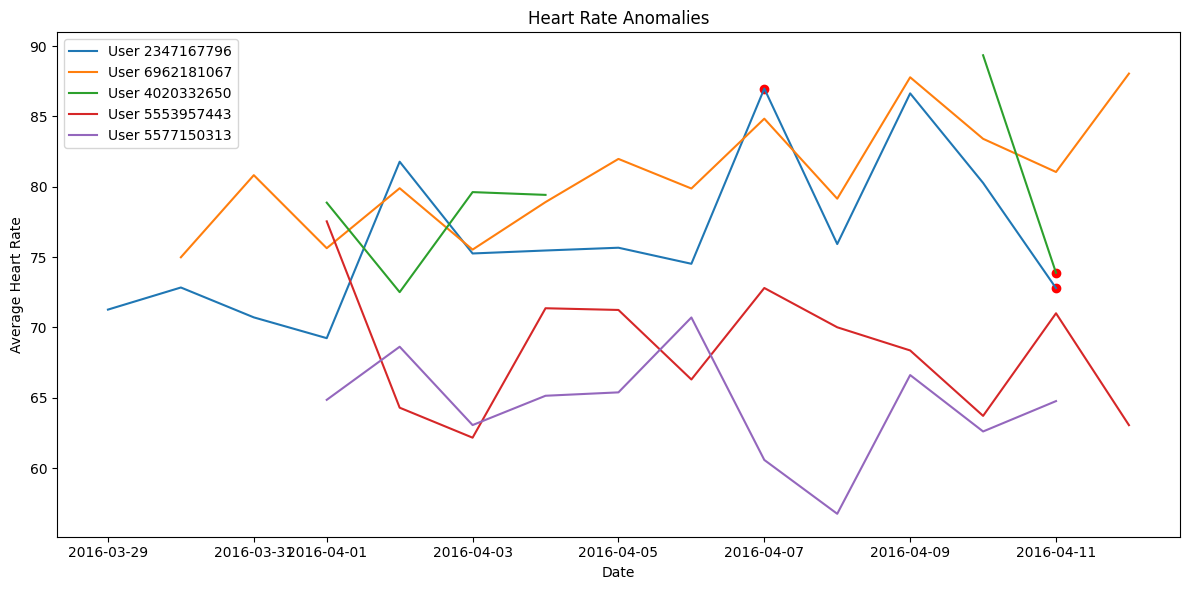

In [39]:
# Plot heart rate anomalies for multiple users
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for uid in user_ids:
    user_data = hr_results[hr_results["user_id"] == uid]

    # Plot heart rate trend
    plt.plot(
        user_data["ds"],
        user_data["y"],
        label=f"User {uid}"
    )

    # Select anomalous points
    anomalies = user_data[user_data["label"] == "Anomalous"]

    # Plot anomalies only if they exist
    if not anomalies.empty:
        plt.scatter(
            anomalies["ds"],
            anomalies["y"],
            color="red",
            marker="o"
        )

plt.title("Heart Rate Anomalies")
plt.xlabel("Date")
plt.ylabel("Average Heart Rate")
plt.legend()
plt.tight_layout()

plt.savefig(
    "/content/drive/MyDrive/FitPulse_Milestone3/Visualisations/heart_rate_anomalies.png"
)

plt.show()


In [42]:
# Sleep Residuals & Anomalies (5 Users)
all_anomalies_sleep = []

for uid in user_ids:
    user_df = df[df["Id"] == uid]

    # Use correct sleep column
    sleep = user_df[["timestamp", "TotalSleepMinutes"]].dropna()
    sleep = sleep.rename(columns={"timestamp": "ds", "TotalSleepMinutes": "y"})
    sleep = sleep.set_index("ds").resample("D").mean().reset_index()

    if len(sleep) < 10:
        continue

    model = Prophet(daily_seasonality=True)
    model.fit(sleep)

    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)

    merged = sleep.merge(forecast[["ds", "yhat"]], on="ds", how="left")
    merged["residual"] = merged["y"] - merged["yhat"]
    merged["user_id"] = uid

    all_anomalies_sleep.append(merged)

sleep_results = pd.concat(all_anomalies_sleep, ignore_index=True)
sleep_results.head()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with we

,ds,y,yhat,residual,user_id
0,2016-03-29,527.0,579.895256,-52.895256,2347167796
1,2016-03-30,563.0,563.706038,-0.706038,2347167796
2,2016-03-31,643.0,547.516820,95.483180,2347167796
3,2016-04-01,410.0,531.327602,-121.327602,2347167796
4,2016-04-02,519.0,515.138384,3.861616,2347167796


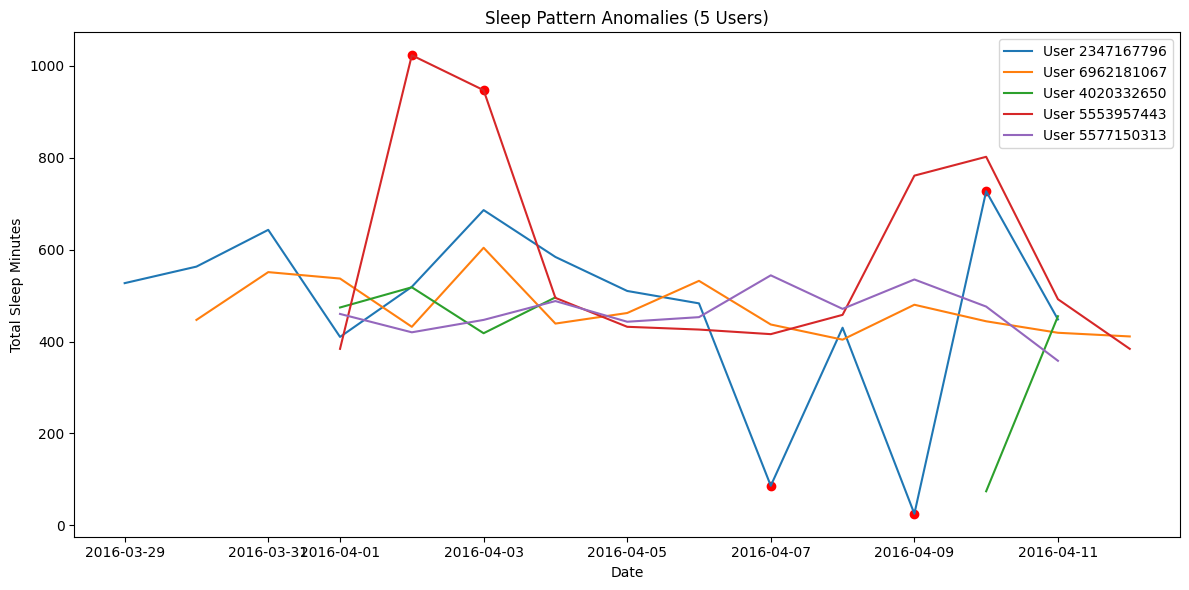

In [43]:
# Abnormal sleep patterns across 5 users are visualized with anomaly markers
import matplotlib.pyplot as plt
import numpy as np

threshold_sleep = 2 * sleep_results["residual"].std()
sleep_results["anomaly"] = np.abs(sleep_results["residual"]) > threshold_sleep

plt.figure(figsize=(12, 6))

for uid in user_ids:
    user_data = sleep_results[sleep_results["user_id"] == uid]

    # Plot sleep trend
    plt.plot(
        user_data["ds"],
        user_data["y"],
        label=f"User {uid}"
    )

    # Plot anomalies
    anomalies = user_data[user_data["anomaly"]]
    if not anomalies.empty:
        plt.scatter(
            anomalies["ds"],
            anomalies["y"],
            color="red",
            marker="o"
        )

plt.title("Sleep Pattern Anomalies (5 Users)")
plt.xlabel("Date")
plt.ylabel("Total Sleep Minutes")
plt.legend()
plt.tight_layout()

plt.savefig(
    "/content/drive/MyDrive/FitPulse_Milestone3/Visualisations/sleep_anomalies.png"
)

plt.show()


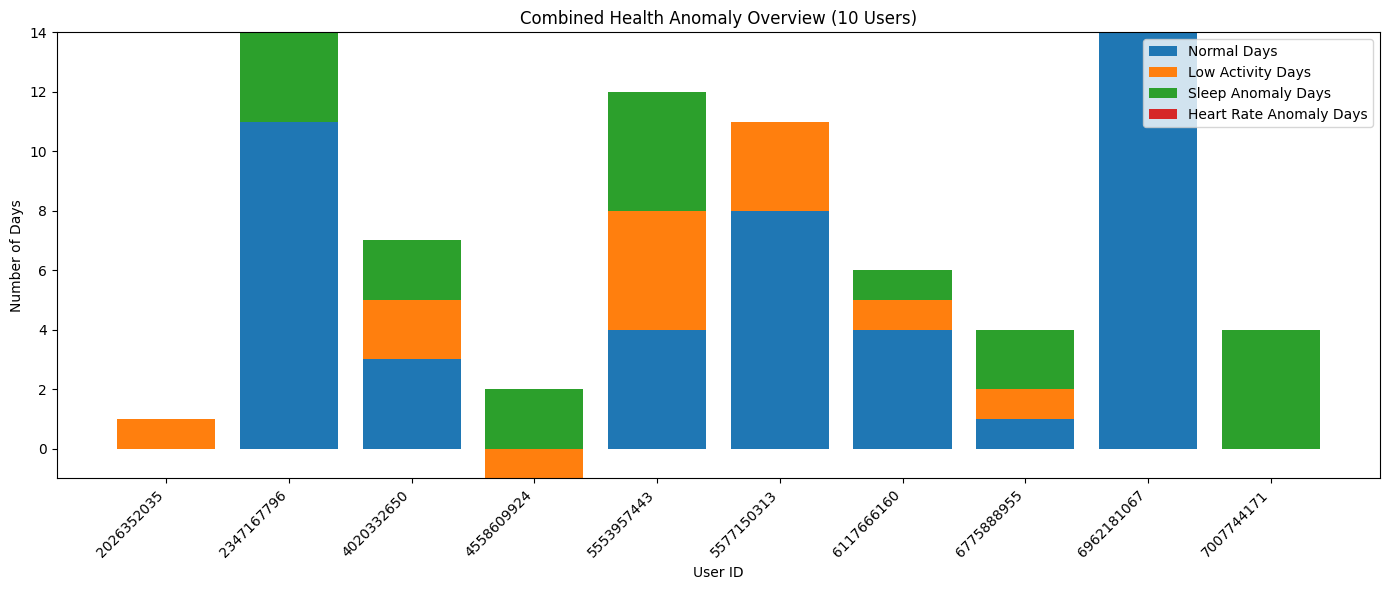

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Load daily merged data
df = pd.read_csv(
    "/content/drive/MyDrive/FitPulse_Milestone1/final_merged_data.csv"
)
df['Date'] = pd.to_datetime(df['Date'])

# Anomaly rules

df['step_anomaly'] = df['TotalSteps'] < 5000
df['sleep_anomaly'] = (df['TotalSleepMinutes'] < 300) | (df['TotalSleepMinutes'] > 600)
df['hr_anomaly'] = df['AvgHeartRate'] > 120

# Aggregate per user

summary = df.groupby('Id').agg(
    HeartRate_Anomaly_Days=('hr_anomaly', 'sum'),
    Sleep_Anomaly_Days=('sleep_anomaly', 'sum'),
    Step_Anomaly_Days=('step_anomaly', 'sum'),
    Total_Days=('Date', 'count')
).reset_index()

summary['Normal_Days'] = (
    summary['Total_Days']
    - summary['HeartRate_Anomaly_Days']
    - summary['Sleep_Anomaly_Days']
    - summary['Step_Anomaly_Days']
)

#  Take 10 users
summary = summary.head(10)

# Plot
plt.figure(figsize=(14,6))

x = summary['Id'].astype(str)

plt.bar(x, summary['Normal_Days'], label='Normal Days')
plt.bar(x, summary['Step_Anomaly_Days'],
        bottom=summary['Normal_Days'], label='Low Activity Days')
plt.bar(x, summary['Sleep_Anomaly_Days'],
        bottom=summary['Normal_Days'] + summary['Step_Anomaly_Days'],
        label='Sleep Anomaly Days')
plt.bar(x, summary['HeartRate_Anomaly_Days'],
        bottom=summary['Normal_Days'] + summary['Step_Anomaly_Days'] + summary['Sleep_Anomaly_Days'],
        label='Heart Rate Anomaly Days')

plt.xlabel("User ID")
plt.ylabel("Number of Days")
plt.title("Combined Health Anomaly Overview (10 Users)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
